# Hamon Evaporation Estimation

The goal here is to take in the csv just as it is, and calculate the evaporation values for each month in the dataset. The result would be a table showing the total evaporation for each month in the dataset

In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
hollis = pd.read_csv("data/Hollis.csv")
hollis.head()

,Date / Time,AirTC (Avg),RH,SlrkW (Avg),SlrjJ (Tot),WS ms (Avg),Wind Dir,T108 C (Avg),HBr3W,Rain mm (Tot)
0,7/17/2014 15:30,26.94,67.85,0.412,609.3776,1.667,335.900,31.21,221.5,0.0
1,7/17/2014 16:00,26.89,69.88,0.387,696.9075,1.618,59.220,31.45,221.4,0.0
2,7/17/2014 16:30,26.45,73.05,0.154,277.9549,1.753,52.930,31.25,221.3,0.0
3,7/17/2014 17:00,26.27,73.78,0.183,328.9092,1.879,2.172,30.91,220.9,0.0
4,7/17/2014 17:30,25.95,75.34,0.060,107.9211,1.944,33.750,30.47,220.8,0.0


In [3]:
hollis.describe()

,AirTC (Avg),RH,SlrkW (Avg),SlrjJ (Tot),WS ms (Avg),Wind Dir,T108 C (Avg),HBr3W,Rain mm (Tot)
count,20054.000000,20054.000000,20054.000000,20054.000000,20054.000000,20054.000000,20054.000000,20054.000000,20054.000000
mean,-0.216621,80.269694,0.174742,314.413236,1.167754,178.645908,27.002141,236.832355,0.170611
std,25.307773,54.656236,0.262976,473.302872,0.797486,123.386771,2.911931,27.208633,1.073114
min,-39.500000,0.612000,0.000000,0.000000,0.000000,-0.990000,20.460000,0.548000,0.000000
25%,-36.300000,7.816250,0.000000,0.000000,0.429000,52.162500,24.770000,212.500000,0.000000
50%,10.825000,91.100000,0.003000,5.817208,1.087000,186.000000,26.440000,247.500000,0.000000
75%,21.300000,119.000000,0.294000,528.021650,1.739000,311.000000,28.960000,259.500000,0.000000
max,30.150000,217.200000,1.150000,2203.842000,4.445000,354.600000,37.270000,301.800000,30.480000


A few things to note. Readings are taken every 30 minutes, and so that obviously needs to get cut down to days. The Hamon evaporation method only takes into account the sunshine hours and daily average temperature, so I could probably get rid of the other columns for now. 

In [4]:
df = hollis[["Date / Time", "T108 C (Avg)"]]    #Using pan temp since air temp has some weird values
df.columns = ['date', 'temp']
df.head()

,date,temp
0,7/17/2014 15:30,31.21
1,7/17/2014 16:00,31.45
2,7/17/2014 16:30,31.25
3,7/17/2014 17:00,30.91
4,7/17/2014 17:30,30.47


Ok I would like to only have daily data. First I think I need to convert the first column to a date object. Check for any nulls first just in case

In [5]:
any_nan = df.columns[df.isnull().any()]
len(list(any_nan))

2

Apparently there was a time where the station was down and a note was made. To remove the nulls

In [6]:
df.dropna(axis=0, subset=["temp"], inplace=True)
any_nan = df.columns[df.isnull().any()]
len(list(any_nan))

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


0

In [7]:
df["date"] = pd.to_datetime(df.date).dt.normalize()
df.head()

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,date,temp
0,2014-07-17,31.21
1,2014-07-17,31.45
2,2014-07-17,31.25
3,2014-07-17,30.91
4,2014-07-17,30.47


In [8]:
df = df.groupby('date', as_index=False, sort=False)['temp'].mean()
df.head()

,date,temp
0,2014-07-17,28.745294
1,2014-07-18,24.944583
2,2014-07-19,25.877708
3,2014-07-20,25.772083
4,2014-07-21,27.385000


In [9]:
df['date'] = pd.to_datetime(df.date)
df.describe()

,temp
count,420.000000
mean,27.004829
std,1.336323
min,23.325000
25%,25.968125
50%,26.921667
75%,28.067812
max,30.116458


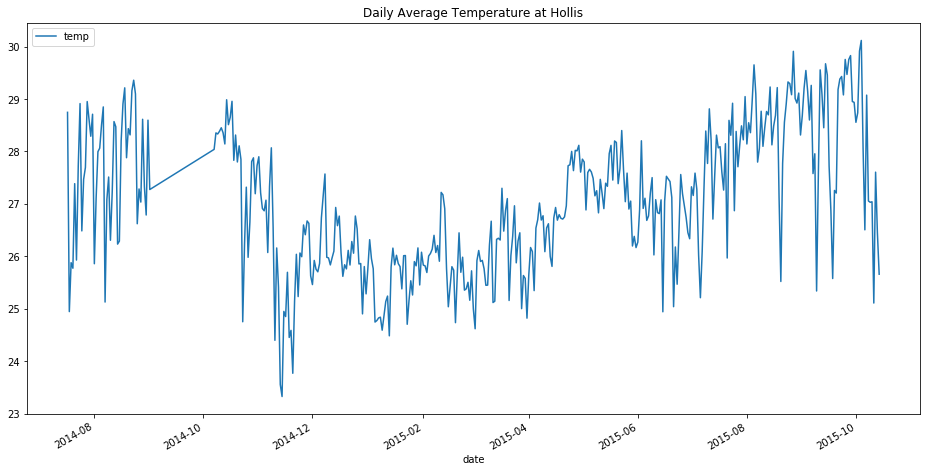

In [10]:
df.plot(x='date', y='temp', figsize=(16,8), title='Daily Average Temperature at Hollis')

Straight line indicates some missing data in September 2014

## Solar Declination 

Looks like we now have the average temperature of each day. Now to start the formulas. First up is the solar declination delta, given by: 

\begin{equation*}
\delta = 0.4093\sin\left({2\pi\over365}J-1.405\right)
\end{equation*}

where J is the Julian Day, or the number of days from the start of the year in other words. So lets make a column with the Julian day

In [11]:
df['julian'] = df['date'].dt.dayofyear
df.head()

,date,temp,julian
0,2014-07-17,28.745294,198
1,2014-07-18,24.944583,199
2,2014-07-19,25.877708,200
3,2014-07-20,25.772083,201
4,2014-07-21,27.385000,202


In [12]:
df['delta'] = df['julian'].apply(lambda x: 0.4093*math.sin(2*math.pi*x/365-1.405))
df.head()

,date,temp,julian,delta
0,2014-07-17,28.745294,198,0.371592
1,2014-07-18,24.944583,199,0.368583
2,2014-07-19,25.877708,200,0.365465
3,2014-07-20,25.772083,201,0.362239
4,2014-07-21,27.385000,202,0.358905


## Sunset hour angle

The formula is:

\begin{equation*}
\omega = arccos(-tan\phi(tan\delta))
\end{equation*}

where phi is the latitude of the resevoir in decimal degrees. For Hollis reservoir it is approximately 10.690243. Be sure to convert to radians in the formula

In [13]:
phi = 10.690243    #latitude of reservoir in decimal degrees

In [14]:
df['sunset'] = df['delta'].apply(lambda x: math.acos(-math.radians(math.tan(phi))*math.tan(x)))
df.head()

,date,temp,julian,delta,sunset
0,2014-07-17,28.745294,198,0.371592,1.592377
1,2014-07-18,24.944583,199,0.368583,1.592185
2,2014-07-19,25.877708,200,0.365465,1.591987
3,2014-07-20,25.772083,201,0.362239,1.591783
4,2014-07-21,27.385000,202,0.358905,1.591572


## Maximum daylight hours

Maximum daylight hours D, is given by:

\begin{equation*}
D = {24\omega\over\pi}
\end{equation*}

In [15]:
df['daylight'] = df['sunset'].apply(lambda x: 24*x/math.pi)
df.head()

,date,temp,julian,delta,sunset,daylight
0,2014-07-17,28.745294,198,0.371592,1.592377,12.164865
1,2014-07-18,24.944583,199,0.368583,1.592185,12.163401
2,2014-07-19,25.877708,200,0.365465,1.591987,12.161886
3,2014-07-20,25.772083,201,0.362239,1.591783,12.160323
4,2014-07-21,27.385000,202,0.358905,1.591572,12.158712


## Saturation Vapour Pressure

In Kilopascals

\begin{equation*}
e_s = 0.6108exp{\left(17.27T_a \over 237.3 + T_a\right)}
\end{equation*}

In [16]:
df['vpressure'] = df['temp'].apply(lambda x: 0.6108*math.exp((17.27*x)/(237.3+x)))
df.head()

,date,temp,julian,delta,sunset,daylight,vpressure
0,2014-07-17,28.745294,198,0.371592,1.592377,12.164865,3.947093
1,2014-07-18,24.944583,199,0.368583,1.592185,12.163401,3.157336
2,2014-07-19,25.877708,200,0.365465,1.591987,12.161886,3.337216
3,2014-07-20,25.772083,201,0.362239,1.591783,12.160323,3.316416
4,2014-07-21,27.385000,202,0.358905,1.591572,12.158712,3.646667


## Celsius to Kelvins

This doesn't need an explanation

In [17]:
df['kelvin'] = df['temp']+273.15
df.head()

,date,temp,julian,delta,sunset,daylight,vpressure,kelvin
0,2014-07-17,28.745294,198,0.371592,1.592377,12.164865,3.947093,301.895294
1,2014-07-18,24.944583,199,0.368583,1.592185,12.163401,3.157336,298.094583
2,2014-07-19,25.877708,200,0.365465,1.591987,12.161886,3.337216,299.027708
3,2014-07-20,25.772083,201,0.362239,1.591783,12.160323,3.316416,298.922083
4,2014-07-21,27.385000,202,0.358905,1.591572,12.158712,3.646667,300.535000


## Saturation Vapour Density

\begin{equation*}
SVD = 2166.74\left(e_s\over T_a\right)
\end{equation*}

SVD is in grams per cubic meter and T<sub>a</sub> is in kelvins

In [18]:
df['SVD'] = 2166.74*(df['vpressure']/df['kelvin'])
df.head()

,date,temp,julian,delta,sunset,daylight,vpressure,kelvin,SVD
0,2014-07-17,28.745294,198,0.371592,1.592377,12.164865,3.947093,301.895294,28.328777
1,2014-07-18,24.944583,199,0.368583,1.592185,12.163401,3.157336,298.094583,22.949517
2,2014-07-19,25.877708,200,0.365465,1.591987,12.161886,3.337216,299.027708,24.181302
3,2014-07-20,25.772083,201,0.362239,1.591783,12.160323,3.316416,298.922083,24.039079
4,2014-07-21,27.385000,202,0.358905,1.591572,12.158712,3.646667,300.535000,26.291043


## Evaporation

\begin{equation*}
E = 0.55\left(D\over 12\right)^2 \left(SVD\over 100\right)
\end{equation*}

where E is in inches per day. I don't know what's with all these unit changes. I'll convert it to mm one time

In [19]:
df['E'] = 0.55*((df['daylight']/12)**2)*(df['SVD']/100)*25.4
df.head()

,date,temp,julian,delta,sunset,daylight,vpressure,kelvin,SVD,E
0,2014-07-17,28.745294,198,0.371592,1.592377,12.164865,3.947093,301.895294,28.328777,4.067020
1,2014-07-18,24.944583,199,0.368583,1.592185,12.163401,3.157336,298.094583,22.949517,3.293954
2,2014-07-19,25.877708,200,0.365465,1.591987,12.161886,3.337216,299.027708,24.181302,3.469888
3,2014-07-20,25.772083,201,0.362239,1.591783,12.160323,3.316416,298.922083,24.039079,3.448593
4,2014-07-21,27.385000,202,0.358905,1.591572,12.158712,3.646667,300.535000,26.291043,3.770656


Now we have estimated daily evaporation values.

## Monthly Evaporation

In [20]:
month_df = df[['date', 'E']]
month_df.set_index('date', inplace=True)
month_df.head()

,E
date,
2014-07-17,4.067020
2014-07-18,3.293954
2014-07-19,3.469888
2014-07-20,3.448593
2014-07-21,3.770656


In [21]:
month_df_sum = month_df.groupby(pd.Grouper(freq="M")).sum()
month_df_sum.head()

,E
date,
2014-07-31,56.776961
2014-08-31,118.274630
2014-09-30,3.686294
2014-10-31,92.720948
2014-11-30,98.963824


In [22]:
month_df_sum.describe()

,E
count,16.000000
mean,94.896673
std,31.838822
min,3.686294
25%,92.975482
50%,103.838681
75%,116.998409
max,123.755762


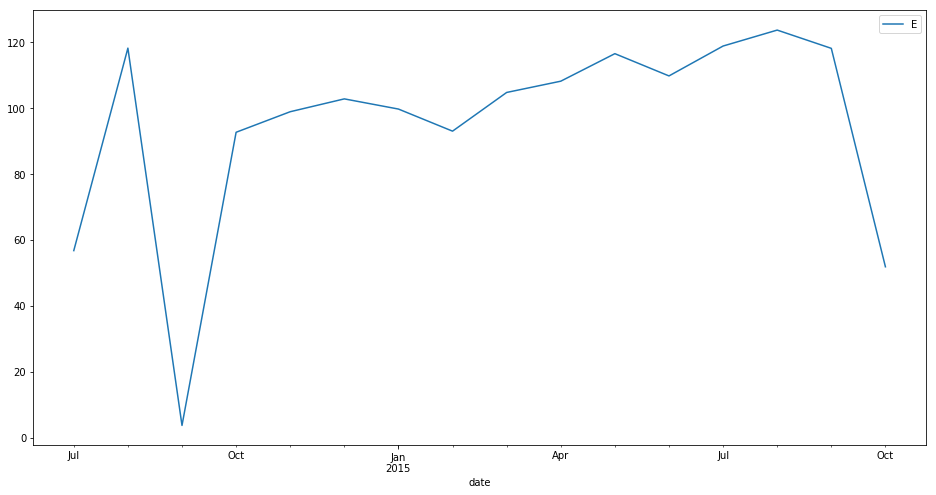

In [23]:
month_df_sum.plot(figsize=(16,8))

We have the problem of incomplete months to deal with, as shown by the drastic changes. Maybe find the mean?

In [24]:
month_df_avg = month_df.groupby(pd.Grouper(freq="M")).mean()
month_df_avg.head()

,E
date,
2014-07-31,3.785131
2014-08-31,3.815311
2014-09-30,3.686294
2014-10-31,3.708838
2014-11-30,3.298794


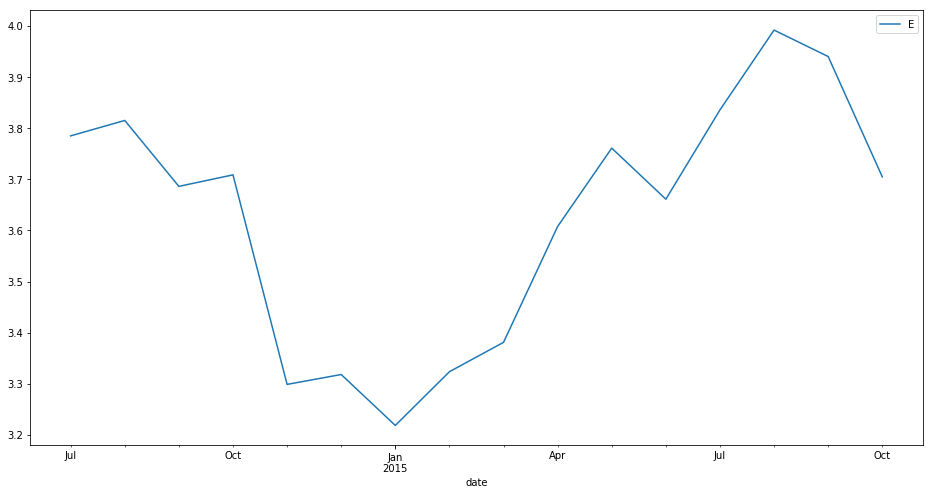

In [25]:
month_df_avg.plot(figsize=(16,8))

Now it may seem that there are huge changes, but that's just some vertical exaggeration here. Everybody is falling between 3 - 4mm, which is a very tiny range.

## Print useable table of values

In [26]:
month_df_sum.to_csv("results/Hamon_month_total.csv")
month_df_avg.to_csv("results/Hamon_month_average.csv")

## Comparison

How does this compare with the actual recorded loss from the evaporation pan? Let's find out. We want the date, water level, and rainfall columns

In [28]:
loss_df = hollis[["Date / Time", "HBr3W", "Rain mm (Tot)"]]    
loss_df.columns = ['date', 'level', 'rainfall']
loss_df.dropna(axis=0, subset=['rainfall'], inplace=True)
loss_df['date'] = pd.to_datetime(loss_df.date).dt.normalize()
loss_df.head()

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,date,level,rainfall
0,2014-07-17,221.5,0.0
1,2014-07-17,221.4,0.0
2,2014-07-17,221.3,0.0
3,2014-07-17,220.9,0.0
4,2014-07-17,220.8,0.0


In [29]:
loss_df = loss_df.groupby('date', as_index=False, sort=False).agg({'level':'first', 'rainfall': 'sum'})
loss_df.head()

,date,rainfall,level
0,2014-07-17,4.572,221.5
1,2014-07-18,25.398,223.8
2,2014-07-19,14.478,247.1
3,2014-07-20,56.646,259.8
4,2014-07-21,1.524,269.2


Need to somehow get the daily change in water level. Diff() function is perfect. Thanks Pandas

In [30]:
loss_df['diff'] = loss_df.level.diff(periods=1) 
loss_df.head()

,date,rainfall,level,diff
0,2014-07-17,4.572,221.5,NaN
1,2014-07-18,25.398,223.8,2.3
2,2014-07-19,14.478,247.1,23.3
3,2014-07-20,56.646,259.8,12.7
4,2014-07-21,1.524,269.2,9.4


And now a rough estimate for evaporation. How often is the evap pan topped up, and to what level? Assume that the pan is not topped up at all in this dataset. The pan overflows at 270